# Window transformer demo
A noteboook to briefly illustrate the main functionanlities and API calls to time series transformations based on moving window. <br>
There are two options for applying window transformation on a TimeSeries: either to use the pandas builtin functions or to provide a user-defined function that will be applied on a moving window on the time series. <br>
The builtins are divided into three windowing modes: 
* A rolling window mode (i.e., "rolling"): the user provides a fixed window size or an offset. The functions in this mode are the following: "count", "sum", "mean", "median", "min", "max", "std", "var", "skew", "kurt", "corr", "cov", "quantile", "sem", "rank". They are based on [pandas.DataFrame.rolling](https://pandas.pydata.org/docs/reference/window.html#api-functions-rolling).
* An exponentially-weighted window mode (i.e., "ewm"): the user needs to specify how to decay the weights of observations in the time series that are being "reduced" together. The functions in this group are the following "ewm_mean", "ewm_var", "ewm_std", "ewm_corr", "ewm_cov", "ewm_sum", "ewm_skew". They are based on [pandas.DataFrame.ewm](https://pandas.pydata.org/docs/reference/window.html#exponentially-weighted-window-functions)
* An expanding window mode (i.e., "expanding"): the window automatically expands with each observation to cover the whole series. The functions in this mode are the following: "count", "sum", "mean", "median", "min", "max", "std", "var", "skew", "kurt", "corr", "cov", "quantile", "sem", "rank". They are based on [pandas.DataFrame.expanding](https://pandas.pydata.org/docs/reference/window.html#expanding-window-functions).

The user-defined function is applied either in the "rolling" mode [pandas.DataFrame.rolling.apply](https://pandas.pydata.org/docs/reference/api/pandas.core.window.rolling.Rolling.apply.html#pandas.core.window.rolling.Rolling.apply) which requires providing the window size, or the "expanding" mode [pandas.DataFrame.expanding.apply](https://pandas.pydata.org/docs/reference/api/pandas.core.window.expanding.Expanding.apply.html#pandas.core.window.expanding.Expanding.apply). 

## Calling window_transform( ) on TimeSeries object

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import linear_timeseries as lt
from darts.datasets import AirPassengersDataset

univ_series = AirPassengersDataset().load()
print(
    "univariate series shape:",
    univ_series._xa.shape,
    " component names:",
    list(univ_series.components),
)
multi_series = univ_series.stack(univ_series + 200)
print(
    "multivariate series shape:",
    multi_series._xa.shape,
    " component names:",
    list(multi_series.components),
)
stochastic_series = multi_series.concatenate(
    multi_series + 200, axis = 2
)  # I added this axis to easily create stochatic series
print(
    "stochastic series shape:",
    stochastic_series._xa.shape,
    " component names:",
    list(stochastic_series.components),
)

univariate series shape: (144, 1, 1)  component names: ['#Passengers']
multivariate series shape: (144, 2, 1)  component names: ['#Passengers', '#Passengers_1']
stochastic series shape: (144, 2, 2)  component names: ['#Passengers', '#Passengers_1']


### Multivariate series transformation

When we don't specify which transformation to be applied on which component, all components 
are transformed with the same function. <br>

component,rolling_mean_3_#Passengers,rolling_mean_3_#Passengers_1
Month,,
1949-01-01,112.000000,312.000000
1949-02-01,115.000000,315.000000
1949-03-01,120.666667,320.666667
1949-04-01,126.333333,326.333333
1949-05-01,127.333333,327.333333
...,...,...
1960-08-01,587.666667,787.666667
1960-09-01,578.666667,778.666667
1960-10-01,525.000000,725.000000


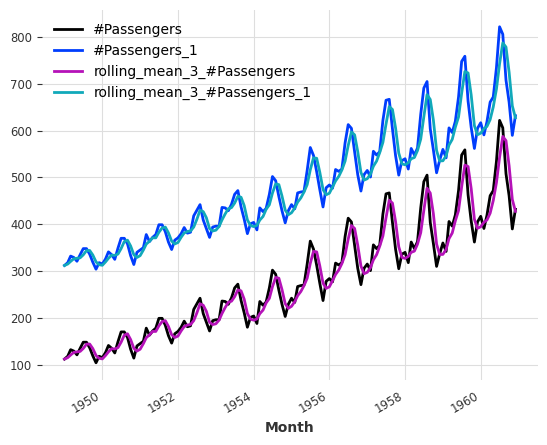

In [2]:
window_transf_dict = {"function": "mean", "mode":"rolling", "window":3}

transformed_m_series = multi_series.window_transform(transforms=window_transf_dict)

multi_series.plot()
transformed_m_series.plot()
transformed_m_series.pd_dataframe()

### Multiple transformation functions
Multiple transformations are provided in a list. Similarly, if not specified all transformations are applied to all components. 

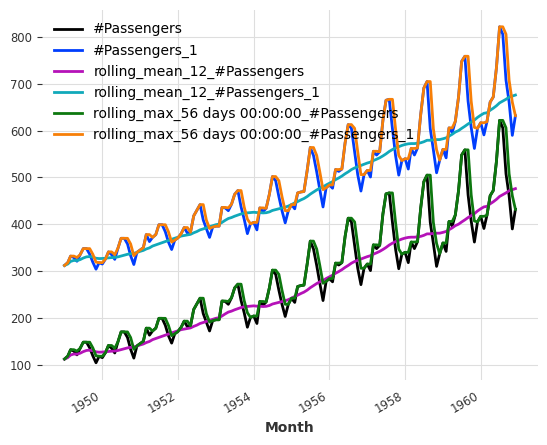

In [4]:
window_transf_dict = [
    {"function": "mean", "mode": "rolling", "window": 12},
    {"function": "max", "mode": "rolling", "window": pd.Timedelta(weeks=8)}, # window as offset
]

transformed_m_series = multi_series.window_transform(transforms=window_transf_dict)

multi_series.plot()
transformed_m_series.plot()

### Specifiying components to transform
To specify components to transform, the user can add the 'components' key to the transformation dictionary. 
The value for this key is a list (or one string) of components names on which to apply the transformation. 

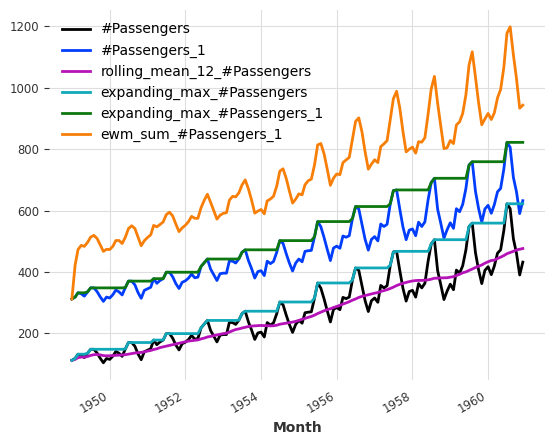

In [7]:
window_transf_dict = [
    {"function": "mean", "mode": "rolling", "window": 12, "components": "#Passengers"},
    {"function": "max", "mode": "expanding", "components": ["#Passengers", "#Passengers_1"]},
    {"function": "sum", "mode": "ewm", "span": 2, "components": "#Passengers_1"},
]

transformed_m_series = multi_series.window_transform(transforms=window_transf_dict)

multi_series.plot()
transformed_m_series.plot()

### Deciding on the returned components after transformation
The user can decide if she wants to return only the transformed components or to return the transformed components along the non-transformed ones.<br>
The argument 'keep_non_transformed' in TimeSeries.window_transform can be set to select one of the two options. It defaults not to return the non transformed. 

Only transformed components output shape: (144, 1, 1)


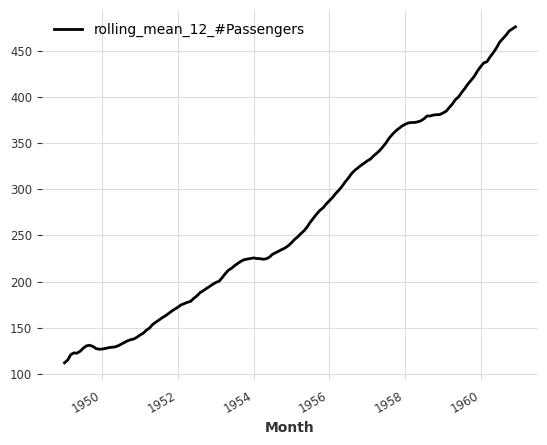

In [8]:
window_transf_dict = [{"function": "mean", "mode": "rolling", "window": 12, "components": "#Passengers"}]

onlytransformed_m_series = multi_series.window_transform(
    transforms=window_transf_dict, keep_non_transformed=False
)

onlytransformed_m_series.plot()
print("Only transformed components output shape:", onlytransformed_m_series._xa.shape)

Transformed and non transformed components output shape: (144, 3, 1)


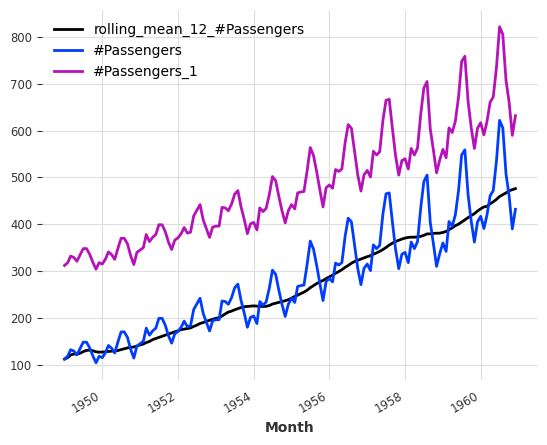

In [9]:
transformedAndNontransformed_m_series = multi_series.window_transform(
    transforms=window_transf_dict, keep_non_transformed=True
)

transformedAndNontransformed_m_series.plot(new_plot=True)
print(
    "Transformed and non transformed components output shape:",
    transformedAndNontransformed_m_series._xa.shape,
)

### Stochastic series
All samples in a stochastic series are transformed in the same manner, there is no option to select different transformations for different samples of a given component. All the previous remains valid and applies in a similar fashion to samples of different components. <br>

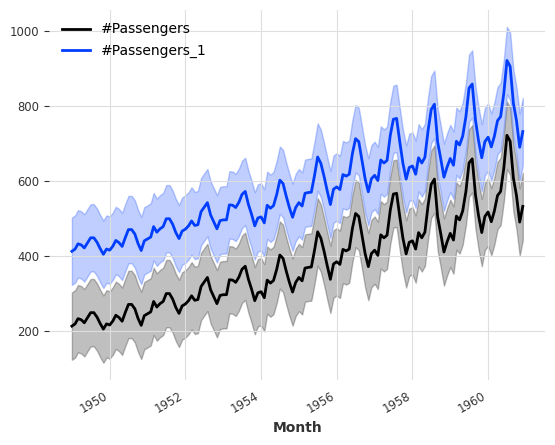

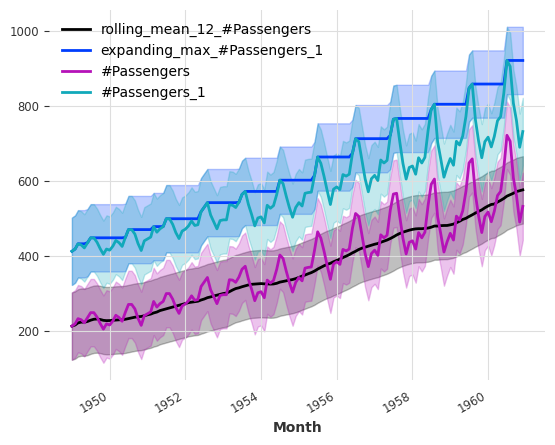

In [12]:
window_transf_dict = [
    {"function": "mean", "mode":"rolling", "window":12, "components": "#Passengers"},
    {"function": "max", "components": ["#Passengers_1"]},
]

transformed_stoch_series = stochastic_series.window_transform(
    transforms=window_transf_dict, keep_non_transformed=True
)

stochastic_series.plot()
transformed_stoch_series.plot(new_plot=True)

### User-defined function
User can provide a function that expects a numpy array (default) and that returns a scalar output. This function can be applied in "rolling" or "expanding" modes. The same behavior applies for selecting components and applying on stochastic series. Keyword arguments to the user-defined function can be provided as additional items in the transformations dictionary.<br>
The user can modify the input type to a pandas.Series by providing the key 'raw' in the transformation dictionary. 

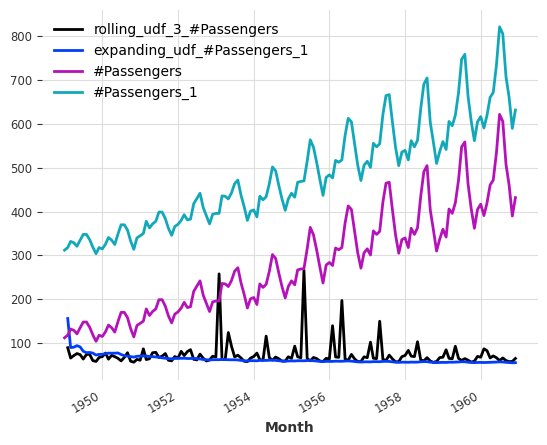

In [14]:
lifted_zscore = lambda x, offset: x[-1] / x.std() + offset  

window_transf_dict = [
    {"function": lifted_zscore, "mode":"rolling", "window": 3, "components": ["#Passengers"], "offset":50},
    {"function": lifted_zscore, "mode":"expanding", "components": ["#Passengers_1"], "offset":50},
]

transformed_m_series = multi_series.window_transform(
    transforms=window_transf_dict, keep_non_transformed=True
)

# multi_series.plot()
transformed_m_series.plot()

# changing the input type to the user-defined function 
window_transf_dict = {"function": lifted_zscore, "window": 5, "raw": False}
# 'raw':False to switch from numpy.ndarray to pandas.Series

### Testing index correct formatting

In [15]:
series = TimeSeries.from_values(np.array([1,2,3,4,5,6]))
transformed_series = series.window_transform({'function':"sum", "mode":"rolling", "window":3})
print("original series index class", series._time_index.__class__)
print("transformed series index class", transformed_series._time_index.__class__)

original series index class <class 'pandas.core.indexes.range.RangeIndex'>
transformed series index class <class 'pandas.core.indexes.range.RangeIndex'>


### Treating NaNs and forecasting safe behavior
As a result of the window transformations, NaNs would only appear at the beginning of the resulting series and only if the "min_periods" parameter was set to else than the defaults (i.e., else than 1 for "rolling" and "expanding" window modes and else than 0 for "ewm" window mode).

The NaNs treatments available is only concerned with NaNs added by the applied transformation. It is possible to set the "treat_na" argument to the following: 
* None: this is the default value. It keeps the NaNs in the resulting series. 
* an integer or float scalar value: in that case all NaNs added by the transformation are replaced by this provided value. NaNs that existed at the beginning of the original series and were not overridden by the transformation are maintained. User can call missing_value_filler tansformer to treat those.  
* "dropna" : to drop the added NaNs at the beginning of the series. If different transformations add a different number of missing values at the beginning of the series, then only the minimal common number of rows is dropped. For example, if a transformation adds 2 NaNs in a column and another adds only 1 NaN, then only 1 row will be dropped. 
* "bfill" or "backfill": to fill the NaNs with the first valid value. Note that if forecasting safe is enforced, this option is not allowed to avoid contaminating the past time steps with observations from the future. If a component starts with NaNs and this NaN was not replaced by the transformation, then the NaNs added by the window transformation in the column will not be replaced. 

To specify if the resulting series is safe to use in forecasting or not, user can set the "forecasting_safe" parameter. It is set to True by default. 

In [2]:
# use a simpler series for easier checking
times = pd.date_range("20130101", "20130110")

series = TimeSeries.from_times_and_values(times, range(1, 11))

multi_series = series.stack(series + 10).concatenate(
    (series + 20).stack(series + 40), axis=2
)  # stochastic series

# introduce a NaN on the first observation of the first component
multi_series.pd_dataframe(copy= False).values[0,0] = 'NaN' 
multi_series.components

Index(['0', '0_1'], dtype='object', name='component')

#### Default - maintain NaNs

In [3]:
# min_periods different from defaults, will add NaNs, differently for each component
window_transform_dict = [{"function": "sum", "mode":"ewm", "span":2, "min_periods":2}, # adds 1 NaN
                         {"function": "sum", "mode":"rolling","window": 3, "min_periods":3}, #adds 2 NaNs
                        {"function": "sum", "mode":"rolling","window": 3, "min_periods":2},] # adds 1 NaN

transformed_series = multi_series.window_transform(transforms=window_transform_dict) 

transformed_series.pd_dataframe(suppress_warnings=True)

,ewm_sum_2_0_s0,ewm_sum_2_0_s1,ewm_sum_2_0_1_s0,ewm_sum_2_0_1_s1,rolling_sum_3_3_0_s0,rolling_sum_3_3_0_s1,rolling_sum_3_3_0_1_s0,rolling_sum_3_3_0_1_s1,rolling_sum_3_2_0_s0,rolling_sum_3_2_0_s1,rolling_sum_3_2_0_1_s0,rolling_sum_3_2_0_1_s1
time,,,,,,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,NaN,29.000000,15.666667,55.666667,NaN,NaN,NaN,NaN,NaN,43.0,23.0,83.0
2013-01-03,3.666667,32.666667,18.222222,61.555556,NaN,66.0,36.0,126.0,5.0,66.0,36.0,126.0
2013-01-04,5.222222,34.888889,20.074074,64.518519,9.0,69.0,39.0,129.0,9.0,69.0,39.0,129.0
2013-01-05,6.740741,36.629630,21.691358,66.506173,12.0,72.0,42.0,132.0,12.0,72.0,42.0,132.0
2013-01-06,8.246914,38.209877,23.230453,68.168724,15.0,75.0,45.0,135.0,15.0,75.0,45.0,135.0
2013-01-07,9.748971,39.736626,24.743484,69.722908,18.0,78.0,48.0,138.0,18.0,78.0,48.0,138.0
2013-01-08,11.249657,41.245542,26.247828,71.240969,21.0,81.0,51.0,141.0,21.0,81.0,51.0,141.0
2013-01-09,12.749886,42.748514,27.749276,72.746990,24.0,84.0,54.0,144.0,24.0,84.0,54.0,144.0


#### Back fill NaNs - only allowed with forecasting_safe = False

In [4]:
# min_periods different from defaults, will add NaNs, differently for each component
window_transform_dict = [{"function": "sum", "mode":"ewm", "span":2, "min_periods":2},
                         {"function": "sum", "mode":"rolling","window": 3, "min_periods":3},
                        {"function": "sum", "mode":"rolling","window": 3, "min_periods":2},]

# "bfill" or "backfill" will only work when forecasting_safe=False
transformed_series = multi_series.window_transform(
    transforms=window_transform_dict, forecasting_safe=False, treat_na = "bfill") 

transformed_series.pd_dataframe(suppress_warnings=True)

,ewm_sum_2_0_s0,ewm_sum_2_0_s1,ewm_sum_2_0_1_s0,ewm_sum_2_0_1_s1,rolling_sum_3_3_0_s0,rolling_sum_3_3_0_s1,rolling_sum_3_3_0_1_s0,rolling_sum_3_3_0_1_s1,rolling_sum_3_2_0_s0,rolling_sum_3_2_0_s1,rolling_sum_3_2_0_1_s0,rolling_sum_3_2_0_1_s1
time,,,,,,,,,,,,
2013-01-01,NaN,29.000000,15.666667,55.666667,NaN,66.0,36.0,126.0,NaN,43.0,23.0,83.0
2013-01-02,NaN,29.000000,15.666667,55.666667,NaN,66.0,36.0,126.0,NaN,43.0,23.0,83.0
2013-01-03,3.666667,32.666667,18.222222,61.555556,NaN,66.0,36.0,126.0,5.0,66.0,36.0,126.0
2013-01-04,5.222222,34.888889,20.074074,64.518519,9.0,69.0,39.0,129.0,9.0,69.0,39.0,129.0
2013-01-05,6.740741,36.629630,21.691358,66.506173,12.0,72.0,42.0,132.0,12.0,72.0,42.0,132.0
2013-01-06,8.246914,38.209877,23.230453,68.168724,15.0,75.0,45.0,135.0,15.0,75.0,45.0,135.0
2013-01-07,9.748971,39.736626,24.743484,69.722908,18.0,78.0,48.0,138.0,18.0,78.0,48.0,138.0
2013-01-08,11.249657,41.245542,26.247828,71.240969,21.0,81.0,51.0,141.0,21.0,81.0,51.0,141.0
2013-01-09,12.749886,42.748514,27.749276,72.746990,24.0,84.0,54.0,144.0,24.0,84.0,54.0,144.0


#### Drop NaNs

In [12]:
# min_periods different from defaults, will add NaNs, differently for each component
window_transform_dict = [{"function": "sum", "mode":"ewm", "span":2, "min_periods":2}, # adds 1 NaN
                         {"function": "sum", "mode":"rolling","window": 3, "min_periods":3}, #adds 2 NaNs
                        {"function": "sum", "mode":"rolling","window": 3, "min_periods":2},] # adds 1 NaN

transformed_series = multi_series.window_transform(transforms=window_transform_dict, treat_na = "dropna")


transformed_series.pd_dataframe(suppress_warnings=True)
# drops only only NaN row, the minimum of 1, 2, 1 added NaNs rows. 

,ewm_sum_2_0_s0,ewm_sum_2_0_s1,ewm_sum_2_0_1_s0,ewm_sum_2_0_1_s1,rolling_sum_3_3_0_s0,rolling_sum_3_3_0_s1,rolling_sum_3_3_0_1_s0,rolling_sum_3_3_0_1_s1,rolling_sum_3_2_0_s0,rolling_sum_3_2_0_s1,rolling_sum_3_2_0_1_s0,rolling_sum_3_2_0_1_s1
time,,,,,,,,,,,,
2013-01-02,NaN,29.000000,15.666667,55.666667,NaN,NaN,NaN,NaN,NaN,43.0,23.0,83.0
2013-01-03,3.666667,32.666667,18.222222,61.555556,NaN,66.0,36.0,126.0,5.0,66.0,36.0,126.0
2013-01-04,5.222222,34.888889,20.074074,64.518519,9.0,69.0,39.0,129.0,9.0,69.0,39.0,129.0
2013-01-05,6.740741,36.629630,21.691358,66.506173,12.0,72.0,42.0,132.0,12.0,72.0,42.0,132.0
2013-01-06,8.246914,38.209877,23.230453,68.168724,15.0,75.0,45.0,135.0,15.0,75.0,45.0,135.0
2013-01-07,9.748971,39.736626,24.743484,69.722908,18.0,78.0,48.0,138.0,18.0,78.0,48.0,138.0
2013-01-08,11.249657,41.245542,26.247828,71.240969,21.0,81.0,51.0,141.0,21.0,81.0,51.0,141.0
2013-01-09,12.749886,42.748514,27.749276,72.746990,24.0,84.0,54.0,144.0,24.0,84.0,54.0,144.0
2013-01-10,14.249962,44.249505,29.249759,74.248997,27.0,87.0,57.0,147.0,27.0,87.0,57.0,147.0


#### Fill with a value  - replace NaNs due to the transformation by the given value

In [13]:
# min_periods different from defaults, will add NaNs, differently for each component
window_transform_dict = [{"function": "sum", "mode":"ewm", "span":2, "min_periods":2}, # adds 1 NaN
                         {"function": "sum", "mode":"rolling","window": 3, "min_periods":3}, #adds 2 NaNs
                        {"function": "sum", "mode":"rolling","window": 3, "min_periods":2},] # adds 1 NaN

transformed_series = multi_series.window_transform(transforms=window_transform_dict, treat_na = 20)


transformed_series.pd_dataframe(suppress_warnings=True)
# all NaNs will be replaced by the provided value
# maintains the pre-existing NaNs

,ewm_sum_2_0_s0,ewm_sum_2_0_s1,ewm_sum_2_0_1_s0,ewm_sum_2_0_1_s1,rolling_sum_3_3_0_s0,rolling_sum_3_3_0_s1,rolling_sum_3_3_0_1_s0,rolling_sum_3_3_0_1_s1,rolling_sum_3_2_0_s0,rolling_sum_3_2_0_s1,rolling_sum_3_2_0_1_s0,rolling_sum_3_2_0_1_s1
time,,,,,,,,,,,,
2013-01-01,20.000000,20.000000,20.000000,20.000000,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
2013-01-02,NaN,29.000000,15.666667,55.666667,20.0,20.0,20.0,20.0,NaN,43.0,23.0,83.0
2013-01-03,3.666667,32.666667,18.222222,61.555556,NaN,66.0,36.0,126.0,5.0,66.0,36.0,126.0
2013-01-04,5.222222,34.888889,20.074074,64.518519,9.0,69.0,39.0,129.0,9.0,69.0,39.0,129.0
2013-01-05,6.740741,36.629630,21.691358,66.506173,12.0,72.0,42.0,132.0,12.0,72.0,42.0,132.0
2013-01-06,8.246914,38.209877,23.230453,68.168724,15.0,75.0,45.0,135.0,15.0,75.0,45.0,135.0
2013-01-07,9.748971,39.736626,24.743484,69.722908,18.0,78.0,48.0,138.0,18.0,78.0,48.0,138.0
2013-01-08,11.249657,41.245542,26.247828,71.240969,21.0,81.0,51.0,141.0,21.0,81.0,51.0,141.0
2013-01-09,12.749886,42.748514,27.749276,72.746990,24.0,84.0,54.0,144.0,24.0,84.0,54.0,144.0


#### Enforcing forecasting safe behavior : 

In [14]:
# Enforcing default forecasting_safe= True : interrupts execution when "center":True and when treat_na='bfill'
window_transform_dict = {"function": "sum", "mode": "rolling", "window":3, "center": True}

transformed_series = multi_series.window_transform(transforms=window_transform_dict)


ValueError: When `forecasting_safe` is True, `center` must be False.


ValueError: When `forecasting_safe` is True, `center` must be False.

In [16]:
# Enforcing default forecasting_safe= True : 
# interrupts execution when "center":True and when treat_na='bfill' or 'backfill'
window_transform_dict = {"function": "sum", "mode": "rolling", "window":3, "min_periods":2}

transformed_series = multi_series.window_transform(transforms=window_transform_dict, treat_na="backfill")


### Flexible parametrization

#### Passing parameters to the underlying functions 
Any argument that needs to be passed to the underlying built-in or user defined functions can be provided as "key:value" pairs in the transformation dictionnary.

In [17]:
# Error : when selecting 'function':'quantile' and not providing the quantile value
window_transform_dict = {"function": "quantile", "window": 3}
transformed_series = multi_series.window_transform(
    transforms=window_transform_dict
)

TypeError: quantile() missing 1 required positional argument: 'quantile'

In [18]:
# providing a 'step' value, a step value larger than 1 changes the frequency of the series
# We don't call it stride, because 'step' is the name of the argument for pandas.DataFrame.rolling
window_transform_dict = {"function": "sum", "mode":"rolling", "window": 3, "step": 2}
transformed_series = multi_series.window_transform(
    transforms=window_transform_dict, forecasting_safe=False
)
print(
    "providing a 'step' value, a step value larger than 1 changes the frequency of the series: \n",
    transformed_series.pd_dataframe(suppress_warnings=True),
)

providing a 'step' value, a step value larger than 1 changes the frequency of the series: 
             rolling_sum_3_0_s0  rolling_sum_3_0_s1  rolling_sum_3_0_1_s0  \
time                                                                       
2013-01-01                 NaN                21.0                  11.0   
2013-01-03                 5.0                66.0                  36.0   
2013-01-05                12.0                72.0                  42.0   
2013-01-07                18.0                78.0                  48.0   
2013-01-09                24.0                84.0                  54.0   

            rolling_sum_3_0_1_s1  
time                              
2013-01-01                  41.0  
2013-01-03                 126.0  
2013-01-05                 132.0  
2013-01-07                 138.0  
2013-01-09                 144.0  


## Creating a ForecastingWindowTransformer
With a ForecastingWindowTransformer the user can provide a sequence of TimeSeries. All series in a sequence will receive the same transformations. If specific components are selected in the transformation dictionary, those components should be common (i.e., have a common name) among all series in the sequence.  

In [2]:
from darts.dataprocessing.transformers.window_transformer import (
    ForecastingWindowTransformer,
)

times = pd.date_range("20130101", "20130110")

series = TimeSeries.from_times_and_values(times, range(1, 11))
series_1 = TimeSeries.from_times_and_values(times, range(1, 11))
series_2 = TimeSeries.from_times_and_values(times, range(1, 11)) * 2

multi_series_1 = series.stack(series + 10).concatenate(
    (series + 20).stack(series + 40), axis=2
)  # stochastic series
multi_series_2 = (series.stack(series + 10).stack((series + 20).stack(series + 40))) * 5

all_series = [series_1, series_2, multi_series_1, multi_series_2]

### Defaults - forecasting safe enforced, return only transformed components, keep NaNs

In [17]:
# same function will apply to all series and all their components
window_transformations = {"function": "sum", "mode":"rolling", "center":True, "window": 3, "min_periods":2}

# defaults to keep NaN and forecasting safe 
transformer_1 = ForecastingWindowTransformer(transforms=window_transformations) 


ValueError: When `forecasting_safe` is True, `center` must be False.


ValueError: When `forecasting_safe` is True, `center` must be False.

### Configure transformation dictionary as needed

transformed_series is a list of length =  4
 
 transformed series id: 0 

component   rolling_sum_3_2_0     0
time                               
2013-01-01                NaN   1.0
2013-01-02                3.0   2.0
2013-01-03                6.0   3.0
2013-01-04                9.0   4.0
2013-01-05               12.0   5.0
2013-01-06               15.0   6.0
2013-01-07               18.0   7.0
2013-01-08               21.0   8.0
2013-01-09               24.0   9.0
2013-01-10               27.0  10.0
 
 transformed series id: 1 

component   rolling_sum_3_2_0     0
time                               
2013-01-01                NaN   2.0
2013-01-02                6.0   4.0
2013-01-03               12.0   6.0
2013-01-04               18.0   8.0
2013-01-05               24.0  10.0
2013-01-06               30.0  12.0
2013-01-07               36.0  14.0
2013-01-08               42.0  16.0
2013-01-09               48.0  18.0
2013-01-10               54.0  20.0
 
 transformed series id: 2 

  

/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_x64_test_local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


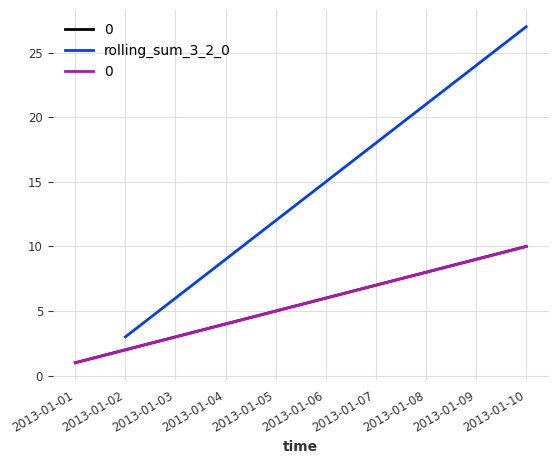

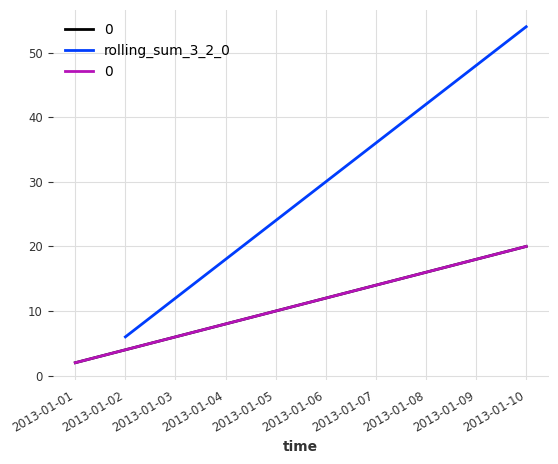

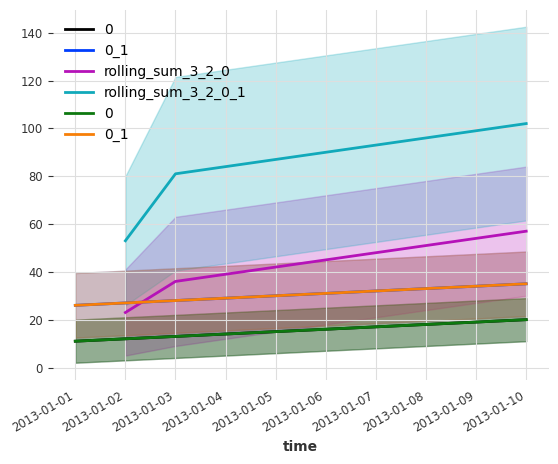

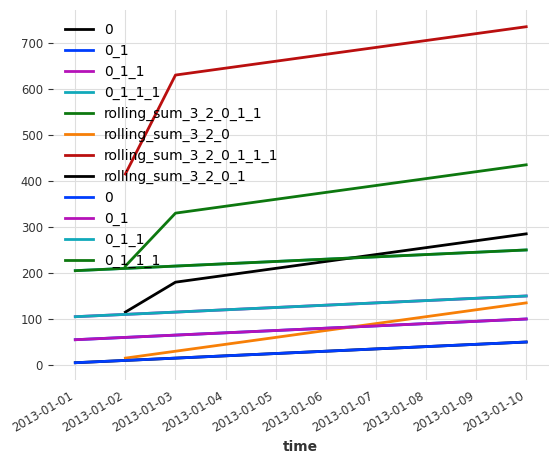

In [20]:
# same function will apply to all series and all their components
window_transformations = {"function": "sum", "mode":"rolling", "window": 3, "min_periods":2}

transformer_2 = ForecastingWindowTransformer(transforms=window_transformations, forecasting_safe=False, 
                                             keep_non_transformed=True) 


transformed_series = transformer_2.transform(all_series)

print("transformed_series is a list of length = ", len(transformed_series))

for idx, transf_s in enumerate(transformed_series):
    print(" \n transformed series id:", idx, "\n")
    print(transf_s.pd_dataframe(suppress_warnings=True))

all_series[0].plot()
transformed_series[0].plot()

all_series[1].plot(new_plot=True)
transformed_series[1].plot()

all_series[2].plot(new_plot=True)
transformed_series[2].plot()

all_series[3].plot(new_plot=True)
transformed_series[3].plot()


## Calling a window transformer in pipeline

In [21]:
from darts.dataprocessing.pipeline import Pipeline
from darts.dataprocessing.transformers import Mapper

window_transformations = [
    {"function": "sum", "window": 3,},
    {"function": "mean", "window": 3},
]


def times_five(x):
    return x * 5


mapper = Mapper(fn=times_five)

window_transformer = ForecastingWindowTransformer(transforms=window_transformations)

pipeline = Pipeline([mapper, window_transformer])

transformed_series = pipeline.fit_transform(all_series) 


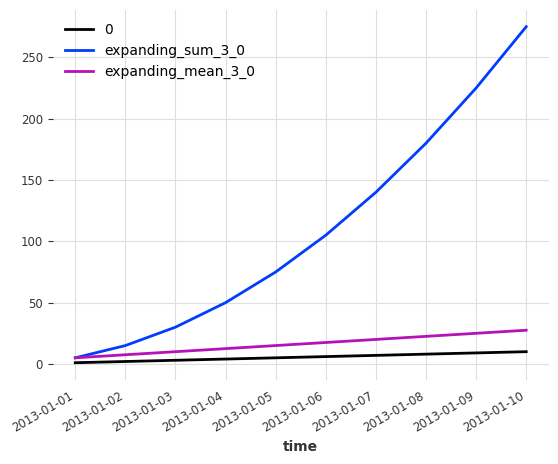

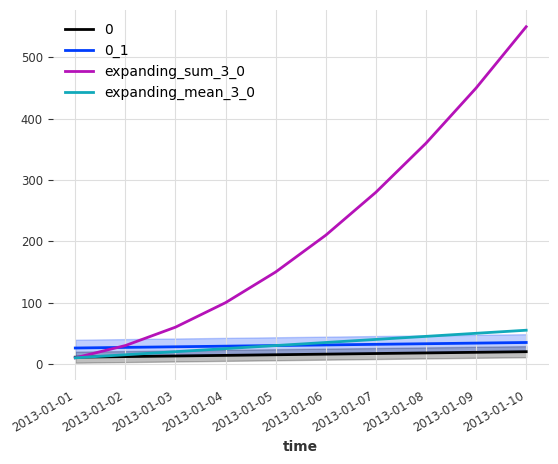

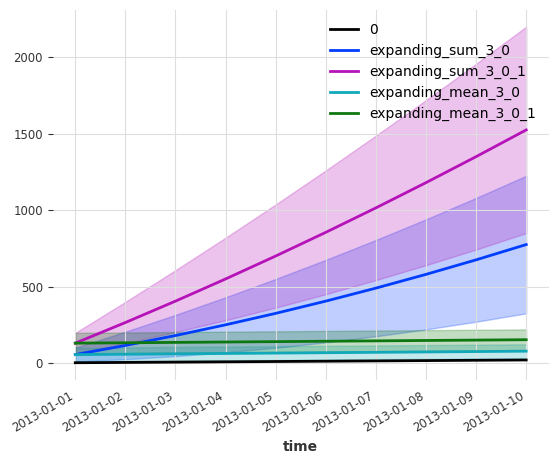

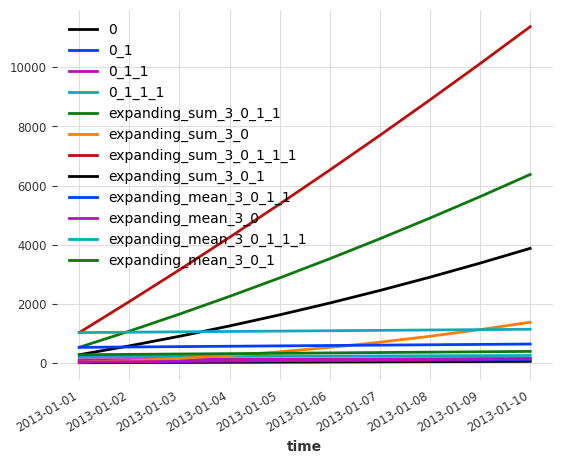

In [22]:
all_series[0].plot()
transformed_series[0].plot()

all_series[2].plot(new_plot=True)
transformed_series[1].plot()


all_series[1].plot(new_plot=True)
transformed_series[2].plot()


all_series[3].plot(new_plot=True)
transformed_series[3].plot()


# Conclusion
This notebook presented the window based transformations available in Darts. Those transformations can be applied on a single time series by directly calling the TimeSeries.window_transform() or on a sequence of TimeSeries by instantiating a ForecastingWindowTransformer object. This transformer can also be called from a pipeline along other transformers. 
Those window transformations are based on the underlying pandas window operations of rolling, expanding and exponentially weighted windows and their implemented reduction functions. A user-provided function can also be applied on the TimeSeries in question. 
By default, all operation of those transformations are garanteed to be forecasting safe by avoiding contamination by future values at their respective present time steps. Furthermore, the output series maintains by default the same length as the input one. 